# Emulator learning

In [ ]:
import time

## Steps 1 and 2

Initial training of the emulator

In [9]:
import theano.tensor as tt

from delfi.inference.BaseInference import BaseInference
from delfi.neuralnet.Trainer import Trainer
from delfi.neuralnet.loss.regularizer import svi_kl_zero

class EmulatorTraining(BaseInference):
    def __init__(self, generator, obs=None, reg_lambda=0.01, seed=None, verbose=True, **kwargs):
        """Training algorithm for emulator

        Parameters
        ----------
        generator : generator instance
            Generator instance
        obs : array or None
            Observation in the format the generator returns (1 x n_summary)
        reg_lambda : float
            Precision parameter for weight regularizer if svi is True
        seed : int or None
            If provided, random number generator will be seeded
        kwargs : additional keyword arguments
            Additional arguments for the NeuralNet instance, including:
                n_components : int
                    Number of components of the mixture density
                n_hiddens : list of ints
                    Number of hidden units per layer of the neural network
                svi : bool
                    Whether to use SVI version of the network or not

        Attributes
        ----------
        observables : dict
            Dictionary containing theano variables that can be monitored while
            training the neural network.
        """
        super().__init__(generator, prior_norm=False,
                         pilot_samples=0, seed=seed,
                         verbose=verbose, **kwargs)
        self.obs = obs
        self.reg_lambda = reg_lambda

    def loss(self, N):
        """Loss function for training

        Parameters
        ----------
        N : int
            Number of training samples
        """
        loss = -tt.mean(self.network.lprobs)

        # keep weights close to zero-centered prior
        kl, _ = svi_kl_zero(self.network.mps, self.network.sps,
                            self.reg_lambda)
        loss = loss + 1/N * kl

        return loss

    def acquisition(self, beta=1.):
        loss = - (tt.mean(self.network.lprobs) + beta*tt.var(self.network.lprobs)) 
        
        
    def run(self, n_train=100, epochs=100, minibatch=50, monitor=None,
            **kwargs):
        """Run algorithm

        Generate training data using the generator. Set up the Trainer with a
        neural net, a loss function and the generated training data. Train the
        network with the specified training arguments.

        Parameters
        ----------
        n_train : int
            Number of training samples
        epochs : int
            Number of epochs used for neural network training
        minibatch : int
            Size of the minibatches used for neural network training
        monitor : list of str
            Names of variables to record during training along with the value
            of the loss function. The observables attribute contains all
            possible variables that can be monitored
        kwargs : additional keyword arguments
            Additional arguments for the Trainer instance

        Returns
        -------
        log: dict
            dict containing the loss values as returned by Trainer.train()
        trn_data : (params, stats)
            training dataset, z-transformed
        posterior : distribution or None
            posterior for obs if obs is not None
        """
        trn_data = self.gen(n_train, verbose=self.verbose)  # z-transformed
        trn_inputs = [self.network.stats, self.network.params]  # flipped (!)

        t = Trainer(self.network, self.loss(N=n_train),
                    trn_data=trn_data, trn_inputs=trn_inputs,
                    monitor=self.monitor_dict_from_names(monitor),
                    seed=self.gen_newseed(), **kwargs)
        log = t.train(epochs=epochs, minibatch=minibatch, verbose=self.verbose)

        posterior = self.predict(self.obs) if self.obs is not None else None

        return log, trn_data, posterior

In [51]:
emul = EmulatorTraining(g, n_hiddens=[10], seed=seed)
log, trn_data, posterior = emul.run(100, epochs=100)

In [84]:
def normal_loglikelihood(mu, sd):
    
    def logp(x):
        return -0.5* ((x - mu) / sd)**2 - 0.5 * tt.log(2* np.pi) - tt.log(sd)
    
    return logp


In [ ]:
f_theta = tt.sum(emul.network.lprobs) + tt.sum(normal_loglikelihood(p.mean[0], p.std[0])(emul.network.stats))
fprime_theta = tt.grad(f_theta, emul.network.stats)

dtype = [('f', 'float32'), ('g', 'float32')]
def make_fun(): 
    eval = theano.function(
        inputs=[emul.network.params, emul.network.stats],
        outputs=[f_theta, fprime_theta],
        on_unused_input='ignore')
    def fun(x, t):
        f, g = eval(x, t)
        return np.array((f, g), dtype=dtype)
    
    return fun

fun = make_fun()

In [209]:
tic = time.time()

M = 50

def make_invoke(M):
    
    def invoke(x, theta):
        v = np.zeros(M, dtype=dtype)
        for m in range(M):
            v[m] = fun(x, theta)
        return v
    return invoke
    

beta = 1.

def loss(v, beta):
    Ef = v['f'].mean()
    Ef2 = (v['f']**2).mean()
    E2f = Ef**2
    return -Ef - beta * (Ef2 - E2f)

def grad(v, beta):
    return -(np.mean(v['g']) + 2 * beta * (np.dot(v['f'], v['g'])/M - np.mean(v['f'])*np.mean(v['g'])))

In [210]:
from tqdm import tqdm

def optimize(f, po, maxiter=1000):
    to, xo = po
    alpha = 0.01
    done = False
    ti = to
    Lo = np.inf
    i = 0
    
#     pbar = tqdm()
    while not done and i < maxiter:
        vi = f(xo, ti)
        L = loss(vi, beta)
        g = grad(vi, beta)
        print(ti, g)
        assert not np.isinf(g)
        assert not np.isnan(g)
        
        ti -= alpha * g
        if np.abs(Lo - L) < 1e-6 * Lo + 1e-6:
            done = True
        Lo = L
        i += 1
#         pbar.update()
    return ti

obs = 0.8 * np.ones((1,1))
theta_s = 0.8 * np.ones((1,1))
obs = obs.astype(np.float32)
theta_s = theta_x.astype(np.float32)

t_star = optimize(make_invoke(M), (theta_s, obs))
t_star

[[ 0.80000001]] 0.906288349628
[[ 0.79093713]] 0.889314367771
[[ 0.78204399]] 0.879783759117
[[ 0.77324617]] 0.867975921631
[[ 0.76456642]] 0.853857171535
[[ 0.75602788]] 0.843418726921
[[ 0.7475937]] 0.829725916386
[[ 0.73929644]] 0.815502128601
[[ 0.73114139]] 0.808148224354
[[ 0.72305989]] 0.790011558533
[[ 0.71515977]] 0.780387103558
[[ 0.70735592]] 0.770337843895
[[ 0.69965255]] 0.754202818871
[[ 0.69211054]] 0.739309279919
[[ 0.68471742]] 0.731251087189
[[ 0.67740488]] 0.719092674255
[[ 0.67021394]] 0.704318597317
[[ 0.66317075]] 0.69454885006
[[ 0.65622526]] 0.681854188442
[[ 0.64940673]] 0.672307069302
[[ 0.64268368]] 0.657935340405
[[ 0.63610435]] 0.644230549335
[[ 0.62966204]] 0.634070606232
[[ 0.62332135]] 0.621271159649
[[ 0.61710864]] 0.606435592175
[[ 0.61104429]] 0.597382671833
[[ 0.60507047]] 0.583911635876
[[ 0.59923136]] 0.573155343533
[[ 0.59349978]] 0.558356275558
[[ 0.5879162]] 0.551923854351
[[ 0.58239698]] 0.535777790546
[[ 0.57703918]] 0.529148890972
[[ 0.571747

[[ 0.38736814]] 0.000596022778191
[[ 0.38736218]] -0.0052687368542
[[ 0.38741487]] -0.00475132472813
[[ 0.38746238]] 0.00831771995872
[[ 0.3873792]] -0.00476699247956
[[ 0.38742688]] -0.00798242609948
[[ 0.38750669]] 0.00429182033986
[[ 0.38746378]] -0.00917863287032
[[ 0.38755557]] -0.00298352865502
[[ 0.3875854]] -0.000427788840607
[[ 0.38758969]] 0.00655741240829
[[ 0.38752413]] -0.00380266493186
[[ 0.38756216]] 0.0025612885505
[[ 0.38753656]] 0.00309659490362
[[ 0.38750559]] 0.00691962005571
[[ 0.38743639]] 0.0127519916743
[[ 0.38730887]] 0.00440926654264
[[ 0.38726476]] 0.00101155404001
[[ 0.38725466]] 0.00303160153329
[[ 0.38722435]] 0.000953783630393
[[ 0.38721481]] 0.00410565476865
[[ 0.38717374]] -0.00280817545019
[[ 0.38720182]] -0.00407272079028
[[ 0.38724256]] -0.00102463921066
[[ 0.38725281]] -0.000154583945405
[[ 0.38725436]] -0.00608382243663
[[ 0.38731518]] 0.00116053857375
[[ 0.38730359]] 0.00458848699927
[[ 0.3872577]] 0.00551537189633
[[ 0.38720253]] 0.00511726725847

[[ 0.38727123]] 0.00237753976136
[[ 0.38724744]] -0.00291711617261
[[ 0.38727662]] -0.000279377782717
[[ 0.38727942]] 0.000852431142703
[[ 0.3872709]] -0.00337077046745
[[ 0.3873046]] 0.00250673661008
[[ 0.38727954]] -0.0046032900922
[[ 0.38732558]] 0.00432330746204
[[ 0.38728234]] 0.00266990950331
[[ 0.38725564]] 0.00643347151577
[[ 0.3871913]] 0.000905035585165
[[ 0.38718224]] -0.00264687155839
[[ 0.3872087]] -0.00317676154897
[[ 0.38724047]] -0.00224205976818
[[ 0.38726288]] -0.00470825733617
[[ 0.38730997]] -0.00453444501385
[[ 0.38735533]] -0.00541620492935
[[ 0.38740948]] 0.0080838701874
[[ 0.38732865]] 0.00971671845764
[[ 0.3872315]] -0.00373781472445
[[ 0.38726887]] 0.00720243908465
[[ 0.38719684]] 0.00166795194149
[[ 0.38718015]] -0.00839940089732
[[ 0.38726413]] -0.000645851703011
[[ 0.3872706]] 0.00315220496617
[[ 0.38723907]] 0.00175404689275
[[ 0.38722152]] 0.0033014260605
[[ 0.38718849]] 0.00993400957435
[[ 0.38708916]] -0.000729301237297
[[ 0.38709646]] -0.00640510527417

array([[ 0.38738522]], dtype=float32)

In [194]:
%debug

> <ipython-input-193-3f13825b5733>(18)optimize()
     16 
     17         assert not np.isinf(g)
---> 18         assert not np.isnan(g)
     19 
     20         ti -= alpha * g

ipdb> ti
array([[ -5.09464726e+14]], dtype=float32)







38it [00:13, 51.48it/s]

ipdb> q


In [211]:
from scipy.optimize import minimize

In [212]:
theta = np.linspace(-10,10,101)
invoke = make_invoke(M)
L = np.zeros(101)
for i, t in enumerate(theta):
    theta_s = np.array([[t]], dtype=np.float32)
    vi = invoke(obs, theta_s)
    L[i] = loss(vi, beta=1.)

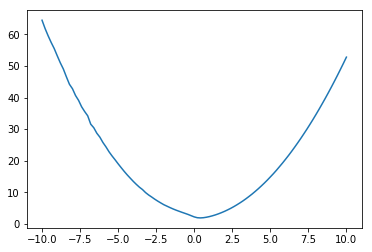

In [213]:
plt.plot(theta, L)

In [171]:
theta[np.argmax(L)]

0.38000000000000012